In [1]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
wordnet = WordNetLemmatizer()
snowballstemmer = SnowballStemmer("english")
stopwords = stopwords.words('english')

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangjiayun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wangjiayun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wangjiayun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

In [12]:
biden_url = 'Biden Tweets - Biden_Tweets copy.csv'
biden = pd.read_csv(biden_url, error_bad_lines= False).drop(['Unnamed: 1', 'Username'], axis = 1)
biden = biden.dropna(subset=["Text"]).reset_index()
test = biden[biden["Sentiment"].notna()].reset_index()
biden = biden[biden["Sentiment"].isna()].reset_index()

In [13]:
#biden

In [14]:
from unidecode import unidecode
from re import sub

def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = remove_polish_letters(text)
    text = str(text)
    text = text.lower()
    
    if 'pic.twitter' in text:
        text = 'empty'

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ", text)
    text = sub(r"\?", " ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " ", text)
    text = sub(r"\s{2,}", " ", text)
    text = sub(r'http\S+', '', text)

    text = text.split()
    text = list(filter(lambda x: len(x) > 1, text))

    return text  

In [15]:
biden["Cleaned_Text"] = biden["Text"].apply(lambda x: text_to_word_list(x, unidecode))

In [16]:
def empty(text):
    is_empty = False
    if text == ['empty']:
        is_empty = True
    return is_empty

def filter_df(df):
    df["is_empty"] = df["Cleaned_Text"].apply(lambda x: empty(x))
    df_filtered = df[df["is_empty"] == False]
    final_df = df_filtered.drop(["is_empty"], axis = 1)
    return final_df

biden = filter_df(biden).reset_index(drop=True)

In [17]:
biden.head()

,level_0,index,timestamp,Retweets,Text,Mentions,Hashtags,Sentiment,Cleaned_Text
0,988,1000,Wed May 01 16:57:00 +0000 2019,0,"That's Joe Biden,Sr. The apple doesn't fall to...",NaN,NaN,NaN,"[that, joe, biden, sr, the, apple, doesn, fall..."
1,989,1001,Wed May 01 16:56:58 +0000 2019,0,wow sexist much?why does the woman need to be ...,NaN,NaN,NaN,"[wow, sexist, much, why, does, the, woman, nee..."
2,991,1003,Wed May 01 16:56:55 +0000 2019,0,Joe+Biden+Takes+the+Lead http://www.BillOReill...,NaN,#,NaN,"[joe, plus, biden, plus, takes, plus, the, plu..."
3,992,1004,Wed May 01 16:56:53 +0000 2019,0,https://twitter.com/ajitxsingh/status/11235660...,NaN,NaN,NaN,"[//twitter, com/ajitxsingh/status/112356607979..."
4,993,1005,Wed May 01 16:56:50 +0000 2019,0,Sad @JoeBiden is loosing it,@JoeBiden,NaN,NaN,"[sad, joebiden, is, loosing, it]"


In [18]:
sentences = biden["Cleaned_Text"].apply(lambda x: " ".join(x))
#sentences

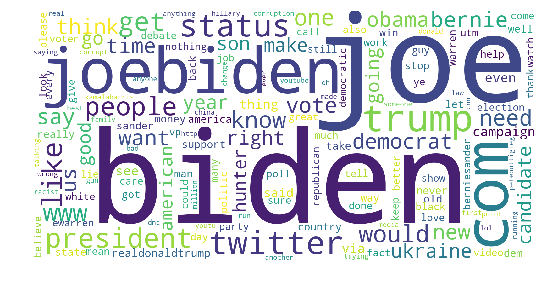

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(sentences)) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [21]:
tokenized_tweet = biden["Cleaned_Text"]
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [that, joe, biden, sr, the, appl, doesn, fall,...
1    [wow, sexist, much, whi, doe, the, woman, need...
2    [joe, plu, biden, plu, take, plu, the, plu, le...
3    [//twitter, com/ajitxsingh/status/112356607979...
4                        [sad, joebiden, is, loos, it]
Name: Cleaned_Text, dtype: object

In [22]:
tokenized_tweet = tokenized_tweet.reset_index(drop=True)
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

biden['Cleaned_Text'] = tokenized_tweet

In [23]:
biden["Cleaned_Text"].head()

0    that joe biden sr the appl doesn fall too far ...
1    wow sexist much whi doe the woman need to be t...
2    joe plu biden plu take plu the plu lead http /...
3    //twitter com/ajitxsingh/status/11235660797903...
4                              sad joebiden is loos it
Name: Cleaned_Text, dtype: object

In [24]:
biden.drop_duplicates(subset=['Cleaned_Text'], keep = 'first',inplace= True)

In [25]:
biden.reset_index(drop=True,inplace=True)

In [26]:
from textblob import TextBlob

def calculate_sentiment(Clean_text):
    return TextBlob(Clean_text).sentiment

def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [28]:
biden['sentiment']=biden.Cleaned_Text.apply(calculate_sentiment)
biden['sentiment_analyser']=biden.Cleaned_Text.apply(calculate_sentiment_analyser)


s = pd.DataFrame(index = range(0,len(biden)),columns= ['compound_score','compound_score_sentiment'])

for i in range(0,len(biden)): 
    s['compound_score'][i] = biden['sentiment_analyser'][i]['compound']
  
    if (biden['sentiment_analyser'][i]['compound'] <= -0.05):
        s['compound_score_sentiment'][i] = 'Negative'    
    if (biden['sentiment_analyser'][i]['compound'] >= 0.05):
        s['compound_score_sentiment'][i] = 'Positive'
    if ((biden['sentiment_analyser'][i]['compound'] >= -0.05) & (biden['sentiment_analyser'][i]['compound'] <= 0.05)):
        s['compound_score_sentiment'][i] = 'Neutral'
    
biden['compound_score'] = s['compound_score']
biden['compound_score_sentiment'] = s['compound_score_sentiment']
biden.head()

,level_0,index,timestamp,Retweets,Text,Mentions,Hashtags,Sentiment,Cleaned_Text,sentiment,sentiment_analyser,compound_score,compound_score_sentiment
0,988,1000,Wed May 01 16:57:00 +0000 2019,0,"That's Joe Biden,Sr. The apple doesn't fall to...",NaN,NaN,NaN,that joe biden sr the appl doesn fall too far ...,"(0.1, 1.0)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral
1,989,1001,Wed May 01 16:56:58 +0000 2019,0,wow sexist much?why does the woman need to be ...,NaN,NaN,NaN,wow sexist much whi doe the woman need to be t...,"(0.3, 0.6666666666666666)","{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp...",0.5859,Positive
2,991,1003,Wed May 01 16:56:55 +0000 2019,0,Joe+Biden+Takes+the+Lead http://www.BillOReill...,NaN,#,NaN,joe plu biden plu take plu the plu lead http /...,"(0.2, 0.4)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral
3,992,1004,Wed May 01 16:56:53 +0000 2019,0,https://twitter.com/ajitxsingh/status/11235660...,NaN,NaN,NaN,//twitter com/ajitxsingh/status/11235660797903...,"(0.0, 0.0)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral
4,993,1005,Wed May 01 16:56:50 +0000 2019,0,Sad @JoeBiden is loosing it,@JoeBiden,NaN,NaN,sad joebiden is loos it,"(-0.5, 1.0)","{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'comp...",-0.4767,Negative


In [29]:
biden.compound_score_sentiment.value_counts()

Positive    15726
Neutral     14030
Negative    13471
Name: compound_score_sentiment, dtype: int64

In [30]:
#tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
# Considering 3 grams and mimnimum frq as 0
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(biden['Cleaned_Text'])
desc_matrix = tf_idf_vect.transform(biden["Cleaned_Text"])

In [31]:
# implement kmeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [32]:
# create DataFrame films from all of the input files.
tweets = {'Tweets': biden["Cleaned_Text"].tolist(), 'Cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters])
frame

,Tweets,Cluster
2,that joe biden sr the appl doesn fall too far ...,2
1,wow sexist much whi doe the woman need to be t...,1
2,joe plu biden plu take plu the plu lead http /...,2
0,//twitter com/ajitxsingh/status/11235660797903...,0
1,sad joebiden is loos it,1
1,hahahahaha not troll realist you,1
1,kamala harri could get some desper need tracti...,1
1,who in the psuck touch child like that,1
1,whi doesnt thi make th point that joebiden ach...,1
1,you should give me fruitcak,1


In [107]:
frame["Cluster"].value_counts()

0    28823
2    11914
1     4170
Name: Cluster, dtype: int64

In [110]:
biden_url = 'Biden Tweets - Biden_Tweets copy.csv'
with_sentiment = pd.read_csv(biden_url, error_bad_lines= False).drop(['Unnamed: 1', 'Username'], axis = 1)
with_sentiment.head(5)

,timestamp,Retweets,Text,Mentions,Hashtags,Sentiment
0,Thu Apr 25 16:59:59 +0000 2019,0,"And, we have President Trump to thank.",NaN,NaN,0.0
1,Thu Apr 25 16:59:59 +0000 2019,0,pic.twitter.com/PxypFuZzdb,NaN,NaN,0.0
2,Thu Apr 25 16:59:58 +0000 2019,0,The “hang em high” references were less than s...,NaN,NaN,0.0
3,Thu Apr 25 16:59:57 +0000 2019,0,"Donald Trump Makes Joe Biden’s Point, Mocking ...",NaN,NaN,-1.0
4,Thu Apr 25 16:59:57 +0000 2019,0,"Factually speaking, that’s not accurate. Trump...",NaN,NaN,-1.0


In [119]:
y_true = with_sentiment[with_sentiment["Sentiment"].notna()]["Sentiment"]
#y_pred = biden[y_true.index]


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977],
           dtype='int64', length=1977)

In [111]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))